In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import torch

## 01/26/22 Getting a feel for the meaning of my network accuracies

In [2]:
from basicModel import EstimateAngle
from datageneration.stimulusGeneration import GratingDataset

In [15]:
model = EstimateAngle.load_from_checkpoint('EstimateAngle/1xnmmok2/checkpoints/epoch=99-step=8000.ckpt')

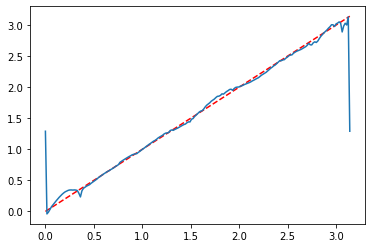

In [20]:
angles = np.linspace(0, np.pi, 201)
test = GratingDataset(angles)


plt.plot(angles, angles, 'r--')
plt.plot( angles, model.forward( test.images).detach())


Ok, this looks like the model is learning pretty well, but theres still an issue with the overlap between small and large angles, which are both being pushed towards $\pi/2$. This can be fixed by making the loss function and / or network output mod pi

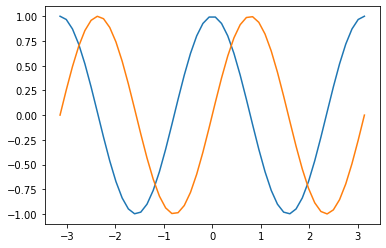

In [25]:
test = np.linspace(-np.pi, np.pi)

plt.plot(test, np.cos(2*test))
plt.plot(test, np.sin(2*test))

In [119]:
def vectorRepresentation( angles):
    """ Implanting angles into Euclidian space, accounting for the fact that 0 = pi
    """
    return torch.stack( (torch.cos(2*angles), torch.sin(2*angles) ) ).T

msloss = torch.nn.MSELoss()


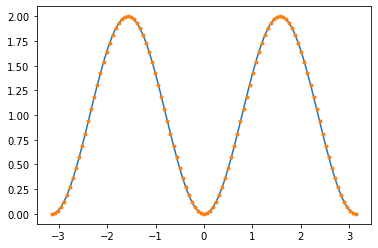

In [137]:
baseAngles = torch.linspace(-np.pi, np.pi, 101)
testAngles = torch.linspace(0, np.pi, 5)

baseVec = vectorRepresentation(baseAngles)
testVec = vectorRepresentation(testAngles)



for test in testVec[0:1]:
    dists = []
    for base in baseVec:
        d = msloss(base, test)
        dists.append(d.numpy())

    plt.plot(baseAngles.numpy(), np.array(dists))
    plt.plot(baseAngles.numpy(), -np.cos(2*baseAngles.numpy()) +1, '.')


Punchline: the vector distance is exactly the cosine of the angle difference! This follows from angle difference identities. I think the vector distance is still easier to implement

## First try with vector distance:
Looks like shit.

In [138]:
model = EstimateAngle.load_from_checkpoint('EstimateAngle/3ms8lyj2/checkpoints/epoch=99-step=8000.ckpt')

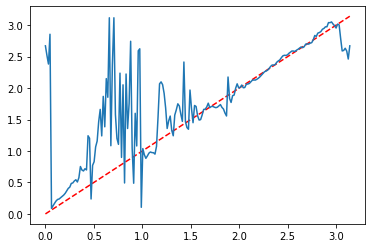

In [145]:
angles = np.linspace(0, np.pi, 201)
test = GratingDataset(angles)


plt.plot(angles, angles, 'r--')
plt.plot( angles, model.forward( test.images).detach() % np.pi  )

In [180]:
%run basicModel.py
model = EstimateAngle.load_from_checkpoint('EstimateAngle/1barre40/checkpoints/epoch=99-step=8000.ckpt')
model.setup(basesize=80)


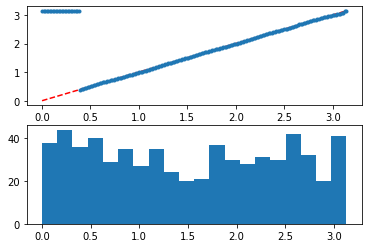

In [181]:
angles = np.linspace(0, np.pi, 201)
test = GratingDataset(angles)

plt.subplots(2, 1)
plt.subplot(2,1,1)
plt.plot(angles, angles, 'r--')
plt.plot( angles, model.forward( test.images).detach(), '.' )

plt.subplot(2,1,2)
plt.hist(model.trainingData.angles, bins=20);




In [201]:
i = 15
model.lossFn(model.forward( test.images).detach()[i], torch.tensor(angles)[i] )

tensor(0.1090, dtype=torch.float64)

It seems strange that the network has so much difficulty learning where to place the cutoff point, when there is a clear signal farther away from zero. It's a strange result

Interestingly, this seems to be a lucky draw. Other seeds don't learn nearly as quickly.

Another option: learn the 2d embedding, then use the angle difference as an objective function.

In [3]:
model = EstimateAngle.load_from_checkpoint('EstimateAngle/2ydkyg3q/checkpoints/epoch=99-step=8000.ckpt')

Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v2.0.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file EstimateAngle/2ydkyg3q/checkpoints/epoch=99-step=8000.ckpt`


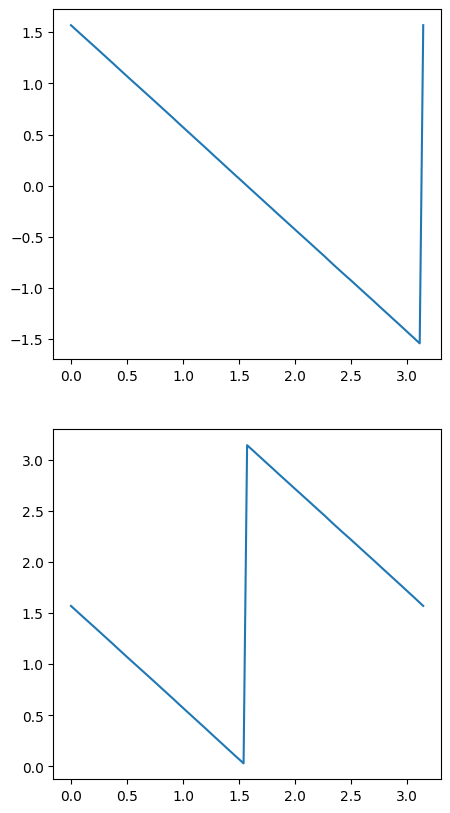

In [17]:
angles = torch.linspace(0, np.pi, 101)
test = GratingDataset(angles)

figsize(5,10)
plt.subplots(2, 1)
plt.subplot(2,1,1)
plt.plot(angles, model.decodeAngles( model.forward(test.images) ).detach() )
plt.subplot(2,1,2)
plt.plot(angles, model.decodeAngles( model.forward(test.images) ).detach() % np.pi)


## Finally, a reasonable encoding

Note that mod $\pi$, everything looks great as it should.

The purely decoded one looks the way it does for two reasons:

1. arctan has the range $[-\pi, \pi]$

2. We're using the half-angle encoding, so the range becomes $[-\pi/2, \pi/2]$ with $-\pi/2 = \pi/2$


Out of curiousity, what is the magnitude?

In [8]:
model.setup(basesize=200)

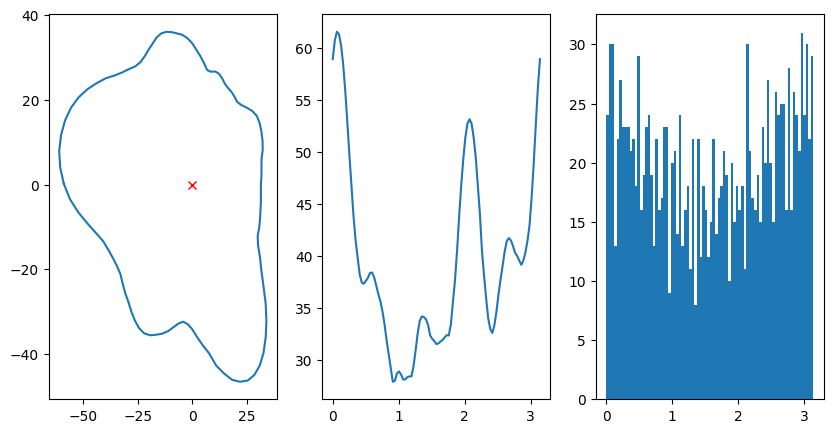

In [19]:
encodings = model.forward( test.images)

figsize(10,5)
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.plot(encodings[:,0].detach(), encodings[:,1].detach())
plt.plot([0], [0], 'rx')

plt.subplot(1,3,2)
plt.plot(angles, torch.norm(encodings, dim=1).detach() )

plt.subplot(1,3,3)
plt.hist(model.trainingData.angles, bins=80);



Not sure if theres a correlation here, but it looks kind of like the radius is largest at the least frequent stimuli.

Question: does the radius reflect the Fisher information? It seems like large radii give more room to make small angle changes, and therefore should correspond to higher Fisher information

# 09/08/23

Exploration to find parameter regions in which the training distribution has an impact on accuracy at different angles. I'm a bit limited on compute, so these runs are more limited than I would like.

I did two sweeps, corresponding together to the following configuration:

```
sweepCFG = {
    'method': 'grid',
    'name': 'DistAndNoiseCharacterization',
    'parameters': {
        'reps': {'values': [0, 1]},
        'kappa_tr': {'values': [1., 2., 4.]},
        'loc_tr': {'values': (np.pi * np.linspace(0, 2, 7)).tolist()[0:2]},
        'shotNoise': {'values': [0.8]},
        'noiseVar': {'values': [1., 10., 20.]},
        'pixelDim': {'values': [101]}
    }
}
```

## Question 1:

Does training mean impact the average accuracy of decoding? 

For the best chance of seeing it, we want the highest possible kappa and noise variance


In [3]:
from experiments import dataFile_initialSweep
from basicModel import EstimateAngle
from datageneration.stimulusGeneration import generateGrating, GratingDataset

mus = (np.pi * np.linspace(0, 2, 7)).tolist()[0:2]

mu0Rep0 =  EstimateAngle.load_from_checkpoint( dataFile_initialSweep( 4, mus[0], 20., 101, 0, 0.8) )
mu0Rep1 =  EstimateAngle.load_from_checkpoint( dataFile_initialSweep( 4, mus[0], 20., 101, 1, 0.8) )

mu1Rep0 =  EstimateAngle.load_from_checkpoint( dataFile_initialSweep( 4, mus[1], 20., 101, 0, 0.8) )
mu1Rep1 =  EstimateAngle.load_from_checkpoint( dataFile_initialSweep( 4, mus[1], 20., 101, 1, 0.8) )


/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:52: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.8, which is newer than your current Lightning version: v2.0.6
  rank_zero_warn(


In [40]:
a= GratingDataset([0., 0., 0.], shotNoise=0.8, noiseVar=20)

In [41]:
(a[2]['image'] == a[1]['image']).all()

tensor(True)

### A large issue:

The data that I was training on all had the same noise instance (due to a programming error). Thus, it's not really noisy, but rather just a distractor. Here I'm sampling new distractors and asking how well the networks do when trained with different means



In [2]:
def testModel(model, reps=1000):
    recon0 = []
    recon1 = []
    for nsamp in range(reps):
        testSample = generateGrating(mus, pixelDim=101, shotNoise=0.8, noiseVar=20)
        t0, t1 = model.decodeAngles( model.forward(testSample) ).detach().numpy()
        recon0.append(t0)
        recon1.append(t1)
    return recon0, recon1


Text(0.5, 0, 'Evaluated at')

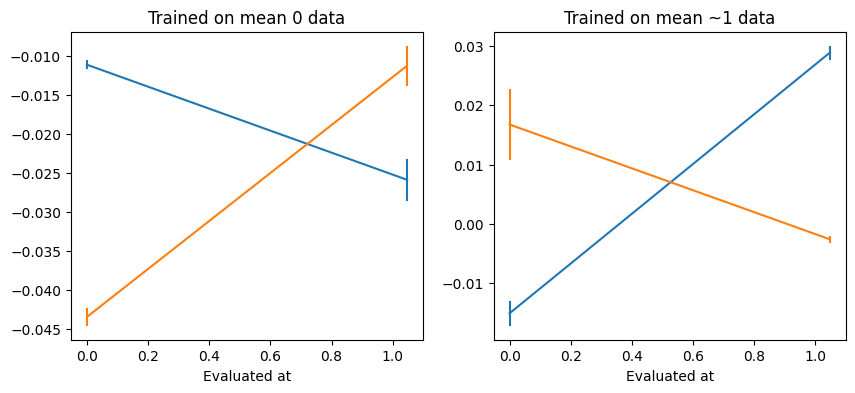

In [111]:
figsize(10,4)
plt.subplots(1,2)

plt.subplot(1,2,1)
r0, r1 = testModel(mu0Rep0)
plt.errorbar(mus, [np.mean(r0)-mus[0], np.mean(r1)-mus[1]], [np.var(r0), np.var(r1)] )
r0, r1 = testModel(mu0Rep1)
plt.errorbar(mus, [np.mean(r0)-mus[0], np.mean(r1)-mus[1]], [np.var(r0), np.var(r1)] )
plt.title('Trained on mean 0 data')
plt.xlabel('Evaluated at')

plt.subplot(1,2,2)
r0, r1 = testModel(mu1Rep0)
plt.errorbar(mus, [np.mean(r0)-mus[0], np.mean(r1)-mus[1]], [np.var(r0), np.var(r1)] )
r0, r1 = testModel(mu1Rep1)
plt.errorbar(mus, [np.mean(r0)-mus[0], np.mean(r1)-mus[1]], [np.var(r0), np.var(r1)] )
plt.title('Trained on mean ~1 data')
plt.xlabel('Evaluated at')


It's possible that there is a significant effect of the training vs evaluation mean on the variance of the output, but doubtful that there is such an effect at the level of the mean. If anything, the learned means are more biased than I would expect. This is probably due to the lack of indepenent noise samples in the training data.

#### What did I expect to see?

Well, I want a measurement of the sensitivity of the encoding to noise. The variance at a single angle is part of the question, but not the full thing. The other piece is the difference between how nearby angles are encoded.

In [125]:
%run discriminationAnalysis.py

In [16]:
sen0_0 = [ sensitivityIndex( mu0Rep0, mus[0]).item(), sensitivityIndex( mu0Rep0, mus[1]).item() ]
sen0_1 = [ sensitivityIndex( mu0Rep1, mus[0]).item(), sensitivityIndex( mu0Rep1, mus[1]).item() ]

sen1_0 = [ sensitivityIndex( mu1Rep0, mus[0]).item(), sensitivityIndex( mu1Rep0, mus[1]).item() ]
sen1_1 = [ sensitivityIndex( mu1Rep1, mus[0]).item(), sensitivityIndex( mu1Rep1, mus[1]).item() ]

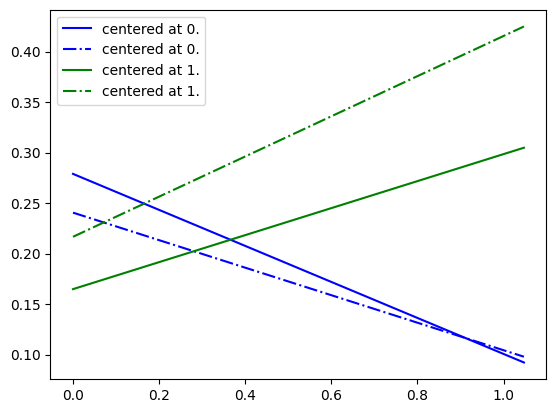

In [20]:
plt.plot(mus, sen0_0, 'b', label='centered at 0.')
plt.plot(mus, sen0_1, '-.b', label='centered at 0.')

plt.plot(mus, sen1_0, 'g', label='centered at 1.')
plt.plot(mus, sen1_1, '-.g', label='centered at 1.')
plt.legend()

This looks promising: the sensitivity is higher at the center of the training distribution than away from it, and additionally, higher in the model centered at a given location than in the other model.

The two models are too close for comfort at 0, but I want to look at models trained on a proper noise distribution to really assess.